In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from xgboost import XGBRegressor


Dataset shape: (6435, 8)

Missing values per column:
 Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

Statistical summary:
              Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    60.663782     3.358607   
std      12.988182  5.643666e+05      0.255049    18.444933     0.459020   
min       1.000000  2.099862e+05      0.000000    -2.060000     2.472000   
25%      12.000000  5.533501e+05      0.000000    47.460000     2.933000   
50%      23.000000  9.607460e+05      0.000000    62.670000     3.445000   
75%      34.000000  1.420159e+06      0.000000    74.940000     3.735000   
max      45.000000  3.818686e+06      1.000000   100.140000     4.468000   

               CPI  Unemployment  
count  6435.000000   6435.000000  
mean    171

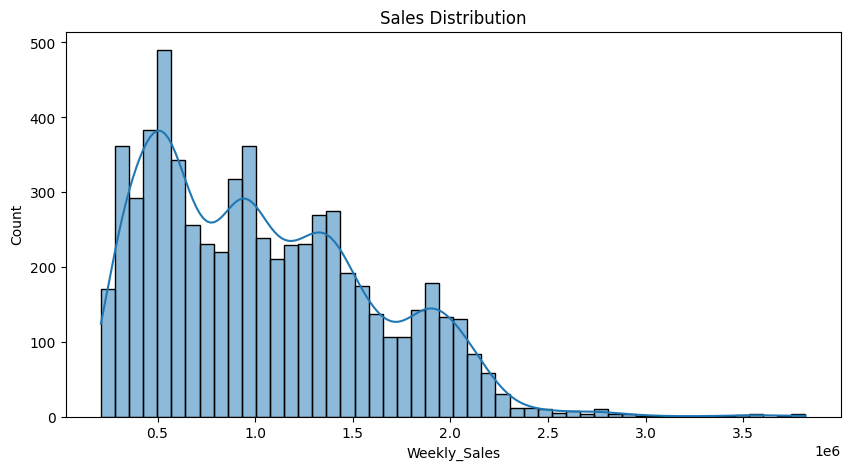

In [4]:

data = pd.read_csv('/content/hi.csv', parse_dates=['Date'])

print("Dataset shape:", data.shape)
print("\nMissing values per column:\n", data.isnull().sum())
print("\nStatistical summary:\n", data.describe())

plt.figure(figsize=(10,5))
sns.histplot(data['Weekly_Sales'], bins=50, kde=True)
plt.title("Sales Distribution")
plt.show()


In [5]:
print("Column names:", data.columns)
print("\nData types:\n", data.dtypes)

print("\nMissing values per column:\n", data.isnull().sum())

print("\nFirst few rows of the dataset:\n", data.head())

Column names: Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

Data types:
 Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

Missing values per column:
 Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

First few rows of the dataset:
    Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    

In [6]:

data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

print(data.head())


   Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05    1643690.90             0        42.31       2.572   
1      1 2010-02-12    1641957.44             1        38.51       2.548   
2      1 2010-02-19    1611968.17             0        39.93       2.514   
3      1 2010-02-26    1409727.59             0        46.63       2.561   
4      1 2010-03-05    1554806.68             0        46.50       2.625   

          CPI  Unemployment  Year  Month  Day  DayOfWeek  IsWeekend  
0  211.096358         8.106  2010      2    5          4          0  
1  211.242170         8.106  2010      2   12          4          0  
2  211.289143         8.106  2010      2   19          4          0  
3  211.319643         8.106  2010      2   26          4          0  
4  211.350143         8.106  2010      3    5          4          0  


In [7]:

print("Holiday_Flag dtype:", data['Holiday_Flag'].dtype)

data = data.drop(['Date'], axis=1)

print(data.head())


Holiday_Flag dtype: int64
   Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0      1    1643690.90             0        42.31       2.572  211.096358   
1      1    1641957.44             1        38.51       2.548  211.242170   
2      1    1611968.17             0        39.93       2.514  211.289143   
3      1    1409727.59             0        46.63       2.561  211.319643   
4      1    1554806.68             0        46.50       2.625  211.350143   

   Unemployment  Year  Month  Day  DayOfWeek  IsWeekend  
0         8.106  2010      2    5          4          0  
1         8.106  2010      2   12          4          0  
2         8.106  2010      2   19          4          0  
3         8.106  2010      2   26          4          0  
4         8.106  2010      3    5          4          0  


In [8]:

print(data['Year'].unique())


[2010 2011 2012]


In [9]:
# Split into Train + Validation (before 2012) and Test (2012)
test = data[data['Year'] == 2012]
train_val = data[data['Year'] < 2012]

print(f"Train + Validation Set: {train_val.shape}, Test Set: {test.shape}")

X_train_val = train_val.drop(['Weekly_Sales'], axis=1)
y_train_val = train_val['Weekly_Sales']
X_test = test.drop(['Weekly_Sales'], axis=1)
y_test = test['Weekly_Sales']


Train + Validation Set: (4500, 12), Test Set: (1935, 12)


In [10]:

scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

print(f"Scaled features for training (first 5 rows):\n {X_train_val[:5]}")


Scaled features for training (first 5 rows):
 [[-1.69397911 -0.29488391 -0.90799526 -1.44852169  1.06603244 -0.09217392
  -1.040833   -1.46050553 -1.20657265  0.          0.        ]
 [-1.69397911  3.39116499 -1.10867616 -1.50321694  1.06980491 -0.09217392
  -1.040833   -1.46050553 -0.40977939  0.          0.        ]
 [-1.69397911 -0.29488391 -1.03368488 -1.58070188  1.07102021 -0.09217392
  -1.040833   -1.46050553  0.38701387  0.          0.        ]
 [-1.69397911 -0.29488391 -0.67985277 -1.47359034  1.07180931 -0.09217392
  -1.040833   -1.46050553  1.18380713  0.          0.        ]
 [-1.69397911 -0.29488391 -0.68671817 -1.32773634  1.07259841 -0.09217392
  -1.040833   -1.15937037 -1.20657265  0.          0.        ]]


In [11]:
tscv = TimeSeriesSplit(n_splits=5)

model = XGBRegressor(n_estimators=100, learning_rate=0.1)

mse_scorer = make_scorer(mean_squared_error)
cv_scores = cross_val_score(model, X_train_val, y_train_val, cv=tscv, scoring=mse_scorer)

print(f"MSE per fold: {cv_scores}")
print(f"Average MSE across folds: {cv_scores.mean()}")


MSE per fold: [5.36210835e+11 3.72791552e+11 2.24238843e+11 2.78781088e+11
 3.07005037e+11]
Average MSE across folds: 343805471243.71405


In [15]:
#checking how well the model is prediciting
model.fit(X_train_val, y_train_val)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

Test RMSE: 201133.8074262064


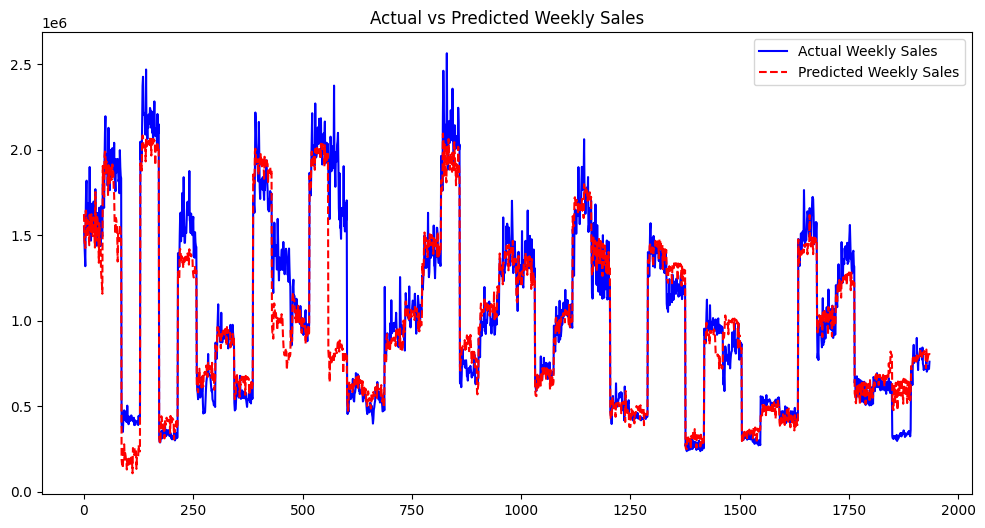

In [16]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Weekly Sales", color='blue')
plt.plot(y_pred, label="Predicted Weekly Sales", color='red', linestyle='dashed')
plt.title("Actual vs Predicted Weekly Sales")
plt.legend()
plt.show()